# Hands-On Session No. 2
## (linear layer implementation and logistic regression)


In [0]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Prepare Data

***The batch dimension.*** Usually, the dimensions of tensors are:
First dimension is the batch ("index" of the sample), then following dimensions are for features. E.g.:

N x D: N samples, each with D features (i.e. N vectors)

N x H x W: N samples, each a 2D "image" of size HxW

In the case of images it is very common to have a "channel" dimension, e.g.:

N x C X H x W: N samples, each a 2D image with C channels. C is most commonly 1 (grayscale image) or 3 (RGB image).

(In this exercise will use NxD tensors)

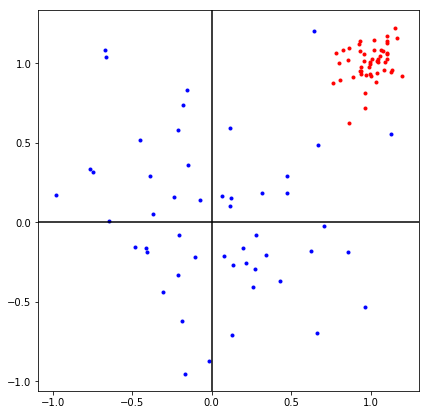

In [0]:
N = torch.tensor(100)
Nhalf = int(N/2)
D = 2

# create linearly separable samples
X1 = 0.1 * torch.randn(Nhalf, D) + torch.tensor([1., 1.])
X2 = 0.5 * torch.randn(N - Nhalf, D)  
X = torch.cat([X1, X2])

# plot data
plt.figure(figsize=(7,7))
plt.plot(X[:X1.shape[0], 0].numpy(), X[:X1.shape[0], 1].numpy(), '.r')
plt.plot(X[X1.shape[0]:, 0].numpy(), X[X1.shape[0]:, 1].numpy(), '.b')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.gca().set_aspect('equal', adjustable='box')

# set labels
y = torch.ones(N).long()
y[:X1.shape[0]] = 0

## Implement a full forward backward Linear layer



In [0]:
# For debugging, put this where you want a breakpoint
# import pdb; pdb.set_trace()    
# To exit breakpoint write 'exit'

class MyLinear(torch.autograd.Function):  
  @staticmethod
  def forward(ctx, x, w, b):
    """
    @param ctx: a context object, where we can save cache (e.g. tensors) for
    later use in the backward part
    @param x, w, b: layer's input, weights, bias respectively
    forward function returns the output of the layer
    """
    # implement the forward part of the layer, that is the output, and 
    # save in ctx whatever you would need for the backward pass
    out = x.matmul(w) + b    
    ctx.save_for_backward(x, w, b)
    return out

  @staticmethod
  def backward(ctx, grad_output):
    """
    @param ctx: context object similar to forward pass (with what you saved)
    @param grad_output: a tensor containing the gradient of the loss function
    with respect to the layer's output.
    
    backward function returns the gradient of the loss w.r.t to each of the
    layer's inputs. you must compute and return it for each input to forward.
    """
    x, w, b = ctx.saved_tensors
#     import pdb; pdb.set_trace()    

    dx = grad_output.matmul(w.t())
    dw = x.t().matmul(grad_output)
    db = grad_output.sum(dim=0)
    
    return dx, dw, db


In [0]:
# number of outputs. For logistic regression we will use one output.
K = 1

# initialize parameters w and b
w = torch.ones(D, K, requires_grad=True, device=device)
b = torch.zeros(K, requires_grad=True, device=device)

# initialize the network
lin = MyLinear()

# check gradients
from torch.autograd import gradcheck
X_check = X.clone().double().requires_grad_(True)
w_check = w.clone().double().requires_grad_(True)
b_check = b.clone().double().requires_grad_(True)
f = lin.apply
gradcheck(f, (X_check,w_check,b_check))

# check everything end to end
out = lin.apply(X, w, b).sigmoid()
loss = torch.nn.BCELoss()(out, y.float().unsqueeze(-1))
loss.backward()
print(loss)

## Train a linear model

In [0]:
# General Parameters
nepochs = 100
lr = 10
K = 1
print_every = 10
#####################

# Initialize paraneters
torch.manual_seed(0)
w = torch.ones(D, K, requires_grad=True, device=device)
b = torch.zeros(K, requires_grad=True, device=device)
lin = MyLinear()

def zero_grad(w):
  if hasattr(w, 'grad'):
    if w.grad is not None:
      w.grad.zero_()
  
# Train model
for t in range(nepochs):
  out = lin.apply(X, w, b).sigmoid()
  loss = torch.nn.BCELoss()(out, y.float().unsqueeze(-1))

  if t % print_every == 0:
    print(t, 'loss:', loss.item())
  
  # compute gradients to parameters
  zero_grad(w)
  zero_grad(b)  
  loss.backward()
  
  # Update parameters
  w.data = w.data - lr * w.grad.data
  b.data = b.data - lr * b.grad.data

print(t, 'loss:', loss.item())

## Verify correctness of solution

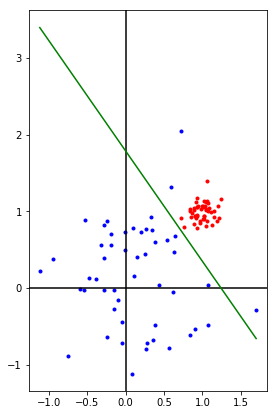

In [0]:
# plot data
plt.figure(figsize=(7,7))
plt.plot(X[:X1.shape[0], 0].numpy(), X[:X1.shape[0], 1].numpy(), '.r')
plt.plot(X[X1.shape[0]:, 0].numpy(), X[X1.shape[0]:, 1].numpy(), '.b')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

xmin = X[:, 0].min()
xmax = X[:, 0].max()
ymin = (-b - w[0] * xmin) / w[1]
ymax = (-b - w[0] * xmax) / w[1]
plt.plot([xmin, xmax], [ymin, ymax], 'g')
plt.gca().set_aspect('equal', adjustable='box')


## Now use pytorch.nn do it for you

In [0]:
# General Parameters
nepochs = 300
lr = 10
K = 1
print_every = 10
#####################

# Initialize paraneters
torch.manual_seed(0)
lin = nn.Linear(D, K) # Changed

# you would have to define your chosen optimizer
optimizer = torch.optim.SGD(lin.parameters(), lr=lr)

def zero_grad(w):
  if hasattr(w, 'grad'):
    if w.grad is not None:
      w.grad.zero_()
  
# Train model
for t in range(nepochs):
  out = lin(X).sigmoid() # Changed
  loss = torch.nn.BCELoss()(out, y.float().unsqueeze(-1))

  if t % print_every == 0:
    print(t, 'loss:', loss.item())
  
  # compute gradients to parameters
  lin.zero_grad() # Changed
  loss.backward()
     
  # update parameters  # Changed
  optimizer.step()
  

print(t, 'loss:', loss.item())

0 loss: 0.7944194078445435
10 loss: 0.19436116516590118
20 loss: 0.17064303159713745
30 loss: 0.1639321744441986
40 loss: 0.16016586124897003
50 loss: 0.15781308710575104
60 loss: 0.156243234872818
70 loss: 0.1551475077867508
80 loss: 0.15435728430747986
90 loss: 0.15377295017242432
100 loss: 0.15333245694637299
110 loss: 0.15299509465694427
120 loss: 0.15273341536521912
130 loss: 0.15252824127674103
140 loss: 0.15236598253250122
150 loss: 0.15223658084869385
160 loss: 0.15213283896446228
170 loss: 0.15204904973506927
180 loss: 0.1519812047481537
190 loss: 0.15192589163780212
200 loss: 0.15188068151474
210 loss: 0.1518436074256897
220 loss: 0.15181313455104828
230 loss: 0.15178795158863068
240 loss: 0.15176714956760406
250 loss: 0.15174990892410278
260 loss: 0.15173563361167908
270 loss: 0.151723712682724
280 loss: 0.15171381831169128
290 loss: 0.1517055630683899
299 loss: 0.15169928967952728


## More Questions

1. Did you manage to converge to zero loss? If not, why?
2. Change data points to overlap (change sigmas and/or means). Try to converge. Did you converge to zero loss? why did you manage (or didn't)?